<a href="https://colab.research.google.com/github/gowtham1997/Analysis_Of_Pruning_Techniques/blob/master/Network_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 380.8MB 83kB/s 
     |████████████████████████████████| 3.8MB 43.9MB/s 
     |████████████████████████████████| 450kB 44.2MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0rc3 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from copy import deepcopy
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# make sure eager execution is on
tf.executing_eagerly()

True

In [5]:
# load and preprocess mnist data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# create a directory to save the files
!mkdir checkpoint

In [0]:
# hyperparameters
NUM_EPOCHS = 15
NUM_CLASSES = 10
BATCH_SIZE = 64
INPUT_SHAPE = (784,)

LAYER_UNITS = (1000, 1000, 500, 200, NUM_CLASSES)

CHECKPOINT_PATH = 'checkpoint/model.h5'
PRUNE_PERCENTILES = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [ ]:
class Linear(Layer):

    """Simple Dense Layer without bias
    Attributes:
        activation (string): Activation function to use
        units (int): Number of units in the dense layer
        w (tf.Tensor): weight matrix
    """

    def __init__(self, units, activation=None, **kwargs):

        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w))

    def get_config(self):
        return {'units': self.units}

In [8]:
def dense_to_sparse(dense_tensor, out_type=tf.int64):
    """Returns params req to convert dense Tensor to a Sparse Tensor

    Args:
        dense_tensor (tf.Tensor): dense Tensor
        out_type (tensorflow.python.framework.dtypes.DType, optional):
                output type for the shape of sparse tensor

    Returns:
        indices, values, shape : params req for sparse tensor conversion
    """
    # Source: https://github.com/tensorflow/tensorflow/issues/15985
    indices = tf.where(tf.not_equal(dense_tensor,
                                    tf.constant(0, dense_tensor.dtype)))
    values = tf.gather_nd(dense_tensor, indices)
    shape = tf.shape(dense_tensor, out_type=out_type)

    return indices, values, shape


class SparseLinear(Layer):

    """Sparse Dense Layer without bias

    Attributes:
        activation (string): Activation function to use
        indices (tf.Tensor):  A 2-D int64 tensor of dense_shape [N, ndims],
                              which specifies the indices of the elements in
                              the sparse tensor that contain nonzero values
        units (tf.Tensor): A 1-D tensor of any type and dense_shape [N], which
                           supplies the values for each element in indices
        values (tf.Tensor): A 1-D int64 tensor of dense_shape [ndims], which
                            specifies the dense_shape of the sparse tensor
        w_T (tf.sparse.SparseTensor): transposed sparse weight matrix
    """

    def __init__(self, units, weights, activation=None, **kwargs):
        # weights are the dense weight matrix to initialise this layer.

        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        indices, values, _ = dense_to_sparse(tf.transpose(weights))

        # tf initializers only expect list/numpy arrays. Hence convert tf
        # tensors to numpy
        self._indices = indices.numpy()
        self._values = values.numpy()

    def build(self, input_shape):
        # Initialise indices and values and create the Sparse weight Tensor

        self.indices = self.add_weight(
            shape=self._indices.shape,
            dtype=tf.int64,
            initializer=tf.constant_initializer(self._indices),
            trainable=False)

        self.values = self.add_weight(
            shape=self._values.shape,
            initializer=tf.constant_initializer(self._values),
            trainable=True)

        self.w_T = tf.SparseTensor(
            self.indices, self.values,
            dense_shape=(self.units, input_shape[1])
        )
        super().build(input_shape)

    def call(self, inputs):
        """

        tf.sparse.sparse_dense_matmul expects sparse tensor as the left operand
        and dense tensor as the right operand. matmul(sparse_W, X) will result
        in shape incompatability error. To fix this, we can do:

        matmul(X, sparse_W) = (matmul(sparse_W^T, X^T))^T
        """

        inputs_T = tf.transpose(inputs)
        X_T = tf.sparse.sparse_dense_matmul(self.w_T, inputs_T)
        X = tf.transpose(X_T)

        return self.activation(X)

    def set_weights(self, weights):
        self.w_T = dense_to_sparse(tf.transpose(weights))

    def get_weights(self, dense=True):
        return tf.transpose(tf.sparse.to_dense(self.w_T))

    def compute_output_shape(self, input_shape):
        return (input_shape[1], self.units)

    def get_config(self):
        return {'units': self.units}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear (Linear)              (None, 1000)              784000    
_________________________________________________________________
linear_1 (Linear)            (None, 1000)              1000000   
_________________________________________________________________
linear_2 (Linear)            (None, 500)               500000    
_________________________________________________________________
linear_3 (Linear)            (None, 200)               100000    
_________________________________________________________________
linear_4 (Linear)            (None, 10)                2000      
Total params: 2,386,000
Trainable params: 2,386,000
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def get_model(input_shape, layer_units, sparse=False, weights=None):
    """
    Creates a dense/sparse model and initialises all its layers with weights
    if provided.

    Args:
        input_shape (Tuple(int,)): input shape
        layer_units (Tuple(int, ...)): tuple of layer units in the model
        sparse (bool, optional): returns dense model if False and Sparse model
                                 if True
        weights (list of numpy arrays, optional):
                        pretrained weights for initializing layers. This is
                        required in case of Sparse Model
    Returns:
        model(tf.keras.Model): model create with parameters
    """

    tf.keras.backend.clear_session()

    if sparse:

        if not weights:
            return NotImplementedError

        model = tf.keras.Sequential()

        for i, units in enumerate(layer_units[:-1]):
            if i == 0:
                model.add(SparseLinear(layer_units[i], weights[i],
                                       activation='relu',
                                       input_shape=input_shape))
                continue
            model.add(SparseLinear(layer_units[i], weights[i],
                                   activation='relu'))

        model.add(SparseLinear(layer_units[-1], weights[-1],
                               activation='softmax'))
    else:

        model = tf.keras.Sequential()

        for i, units in enumerate(layer_units[:-1]):
            if i == 0:
                model.add(Linear(layer_units[i],
                                 activation='relu',
                                 input_shape=input_shape))
                continue

            model.add(Linear(layer_units[i],
                             activation='relu'))

        model.add(Linear(layer_units[-1], activation='softmax'))
        if weights:
            model.set_weights(weights)

    model.compile(
        loss=sparse_categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy'])
    return model

In [ ]:
model = get_model(INPUT_SHAPE, LAYER_UNITS)
print(model.summary())

In [9]:
if tf.__version__ == '2.0.0':
    monitor = 'val_accuracy'
else:
    monitor = 'val_acc'

# use a callback to save the best model when there is an increase
# in the val accuracy
checkpoint = ModelCheckpoint(filepath=CHECKPOINT_PATH,
                              monitor=monitor,
                              save_best_only=True,
                              verbose=1,
                              mode='max')

model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          verbose=1,
          shuffle=True,
          callbacks=[checkpoint],
          validation_data=(x_test, y_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/15
59904/60000 [============================>.] - ETA: 0s - loss: 0.1964 - accuracy: 0.9416
Epoch 00001: val_accuracy improved from -inf to 0.96980, saving model to checkpoint/model.h5
60000/60000 [==============================] - 7s 121us/sample - loss: 0.1964 - accuracy: 0.9415 - val_loss: 0.1004 - val_accuracy: 0.9698
Epoch 2/15
59968/60000 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9734
Epoch 00002: val_accuracy improved from 0.96980 to 0.97530, saving model to checkpoint/model.h5
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0882 - accuracy: 0.9734 - val_loss: 0.0825 - val_accuracy: 0.9753
Epoch 3/15
59712/60000 [============================>.] - ETA: 0s - loss: 0.0642 - accuracy: 0.9812
Epoch 00003: val_accuracy did not improve from 0.97530
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0641 - accuracy: 0.9812 - val_loss: 0.0963 - val_accurac

In [10]:
# evaluate the model
model = get_model(INPUT_SHAPE, LAYER_UNITS)
model.load_weights(CHECKPOINT_PATH)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.0910469792087715
Test accuracy: 0.983
Test loss: 0.0910469792087715
Test accuracy: 0.983
Test loss: 0.0910469792087715
Test accuracy: 0.983
Test loss: 0.0910469792087715
Test accuracy: 0.983
1 loop, best of 3: 1.08 s per loop


In [1]:
def weight_pruning(layer_weights, percentile):
    """Prune weights by magnitude and set to zero the smallest k%

    Args:
        layer_weights (list of numpy arrays): layer weights of pretrained model
        percentile (int): percentage of weight to prune

    Returns:
        pruned weights after weight pruning
    """
    pruned_weights = []

    # layer_weights[:-1] is used as we shouldn't prune the last layer
    for layer, weights in enumerate(layer_weights[:-1]):
        absolute_weights = np.abs(deepcopy(weights))
        # get the top k percentile weights
        thresh = np.percentile(absolute_weights, percentile)
        mask = absolute_weights < thresh
        # zero the weights whose values are less than the threshold value
        weights[mask] = 0
        pruned_weights.append(weights)

    pruned_weights.append(layer_weights[-1])
    return pruned_weights


def unit_pruning(layer_weights, percentile):
    """Prune columns(neurons) of weight matrix according to their L2-norm and
       and delete the smallest k%
    Args:
        layer_weights (list of numpy arrays): layer weights of pretrained model
        percentile (int): percentage of weight to prune

    Returns:
        pruned weights after unit pruning
    """
    pruned_weights = []
    # as we remove neurons the layer units, hence we need to keep track of
    # modified layer units
    layer_units = []
    # We have to remember the active neurons(rows) corresponding to the non-zero
    # columns of the prev layer.
    active_rows = None
    # layer_weights[:-1] is used as we shouldn't prune the last layer
    for layer, weights in enumerate(layer_weights[:-1]):

        if active_rows is not None:
            # only use the active rows(neurons) which correpond to nonzero
            # columns of prev layer
            weights = weights[active_rows, :]

        column_norms = np.linalg.norm(weights,
                                      ord=2, axis=0)
        # get the top k percentile col norms
        thresh = np.percentile(column_norms, percentile)
        active_columns = column_norms >= thresh
        # keep only the active columns(nonzero columns)
        weights = weights[:, active_columns]

        active_rows = active_columns

        layer_units.append(weights.shape[1])

        pruned_weights.append(weights)

    # only use the active rows(neurons) which correpond to nonzero
    # columns of prev layer. Note there is no pruning done for the last layer
    layer_weights[-1] = layer_weights[-1][active_rows, :]
    layer_units.append(layer_weights[-1].shape[1])

    pruned_weights.append(layer_weights[-1])
    return pruned_weights, layer_units

In [ ]:
def prune_and_evaluate_model(weights_to_prune,
                             pruning_type,
                             percentile,
                             input_shape,
                             layer_units,
                             sparse=False,
                             device='gpu'):
    """
    Prunes the model according to the pruning_type(weight/unit) and evaluates
    model performance on the mnist test set

    Args:
        weights_to_prune (list of numpy arrays): pretrained weights to prune
        pruning_type (string): 'weight' or 'unit'
        percentile (int): percentage of weights/neurons to zero/remove
        input_shape (Tuple(int,)): input shape
        layer_units (Tuple(int, ...)): tuple of layer units in the model
        sparse (bool, optional): uses dense model if False and Sparse model
                                 if True
        device (str, optional): Device to run calculations on

    Returns:
        test accuracy of the pruned model

    Raises:
        NotImplementedError: pruning_type is something other than 'weight' or
                             'unit'
    """
    if device == 'gpu':
        device = '/gpu:0'
    else:
        device = '/cpu:0'

    if pruning_type == 'weight':
        pruned_weights = weight_pruning(weights_to_prune, percentile)
    elif pruning_type == 'unit':
        pruned_weights, new_layer_units = unit_pruning(weights_to_prune,
                                                       percentile)
        layer_units = new_layer_units
    else:
        raise NotImplementedError()
    if not sparse:
        model = get_model(input_shape, layer_units, sparse=sparse)
        model.set_weights(pruned_weights)
    else:
        model = get_model(input_shape, layer_units,
                          sparse=sparse, weights=pruned_weights)

    with tf.device(device):
        t1 = time.time()
        _, test_acc = model.evaluate(x_test, y_test,
                                     verbose=0, batch_size=8)
        t2 = time.time()

    print(f"Test accuracy of the model after {pruning_type} pruning with" +
          f" {percentile}% sparsity is {test_acc:.2f}" +
          f". Time taken {(t2 - t1):.2f} seconds")

    return test_acc


Running weight pruning on gpu

Test accuracy of the model after weight pruning with 0 weights removed is 0.98. Time taken 2.87 seconds
Test accuracy of the model after weight pruning with 25 weights removed is 0.98. Time taken 3.01 seconds
Test accuracy of the model after weight pruning with 50 weights removed is 0.98. Time taken 3.10 seconds
Test accuracy of the model after weight pruning with 60 weights removed is 0.98. Time taken 3.07 seconds
Test accuracy of the model after weight pruning with 70 weights removed is 0.98. Time taken 3.11 seconds
Test accuracy of the model after weight pruning with 80 weights removed is 0.98. Time taken 3.10 seconds
Test accuracy of the model after weight pruning with 90 weights removed is 0.94. Time taken 3.24 seconds
Test accuracy of the model after weight pruning with 95 weights removed is 0.51. Time taken 3.09 seconds
Test accuracy of the model after weight pruning with 97 weights removed is 0.37. Time taken 3.09 seconds
Test accuracy of the mod

Text(0.5, 1.0, 'Weight Pruning vs Unit Pruning')

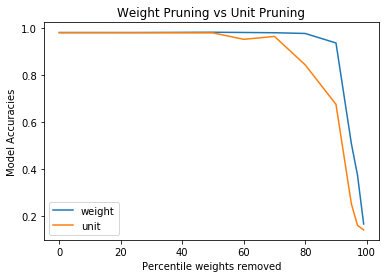

In [13]:
device = 'gpu'
pruning_types = ['weight', 'unit']


for pruning_type in pruning_types:

    pruning_accuracies = []
    print(f'\nRunning {pruning_type} pruning on {device}\n')
    for percentile in PRUNE_PERCENTILES:

        test_acc = prune_and_evaluate_model(
            weights_to_prune=model.get_weights(),
            pruning_type=pruning_type,
            percentile=percentile,
            input_shape=INPUT_SHAPE,
            layer_units=LAYER_UNITS,
            sparse=False,
            device=device)

        pruning_accuracies.append(test_acc)
    plt.plot(PRUNE_PERCENTILES, pruning_accuracies, label=pruning_type)

plt.xlabel('Sparsity (%)')
plt.ylabel('Model Accuracies')
plt.legend(loc='lower left')
plt.title(f'Weight Pruning vs Unit Pruning')

In [0]:
def prune_and_time_model(weights_to_prune,
                         pruning_type,
                         percentile,
                         input_shape,
                         layer_units,
                         sparse=False,
                         device='gpu'):
    """Prunes the model according to the pruning_type(weight/unit) and measures
    the time taken to run mnist test data without batching

    Note: The Mnist test data is loaded as a whole to avoid measuring time taken
          during batching

    Args:
        weights_to_prune (list of numpy arrays): pretrained weights to prune
        pruning_type (string): 'weight' or 'unit'
        percentile (int): percentage of weights/neurons to zero/remove
        input_shape (Tuple(int,)): input shape
        layer_units (Tuple(int, ...)): tuple of layer units in the model
        sparse (bool, optional): uses dense model if False and Sparse model
                                 if True
        device (str, optional): Device to run calculations on

    Returns:
        test accuracy of the pruned model

    Raises:
        NotImplementedError: pruning_type is something other than 'weight' or
                             'unit'
    """
    if device == 'gpu':
        device = '/gpu:0'
    else:
        device = '/cpu:0'

    # https://github.com/tensorflow/tensorflow/issues/12475
    assert (device != 'gpu' and sparse is True), \
        "tf sparse_to_dense_matmul is not optimised for big batch_size on gpu"

    if pruning_type == 'weight':
        pruned_weights = weight_pruning(weights_to_prune, percentile)
    elif pruning_type == 'unit':
        pruned_weights, new_layer_units = unit_pruning(weights_to_prune,
                                                       percentile)
        layer_units = new_layer_units
    else:
        raise NotImplementedError()
    if not sparse:
        model = get_model(input_shape, layer_units, sparse=sparse)
        model.set_weights(pruned_weights)
    else:
        model = get_model(input_shape, layer_units,
                          sparse=sparse, weights=pruned_weights)

    with tf.device(device):
        t1 = time.time()
        _ = model.predict_on_batch(x_test)
        t2 = time.time()

    return (t2 - t1)


Running weight pruning on cpu and evaluating performance on sparse matrix

Time taken for weight pruning  with 0 weights removed is  6.63 seconds
Time taken for weight pruning  with 25 weights removed is  4.97 seconds
Time taken for weight pruning  with 50 weights removed is  3.35 seconds
Time taken for weight pruning  with 60 weights removed is  2.81 seconds
Time taken for weight pruning  with 70 weights removed is  2.26 seconds
Time taken for weight pruning  with 80 weights removed is  1.57 seconds
Time taken for weight pruning  with 90 weights removed is  0.92 seconds
Time taken for weight pruning  with 95 weights removed is  0.60 seconds
Time taken for weight pruning  with 97 weights removed is  0.47 seconds
Time taken for weight pruning  with 99 weights removed is  0.35 seconds

Running weight pruning on cpu and evaluating performance on dense matrix

Time taken for weight pruning  with 0 weights removed is  0.88 seconds
Time taken for weight pruning  with 25 weights removed is  

Text(0.5, 1.0, 'Benchmarking Dense/Sparse operations with Weight/Unit pruning')

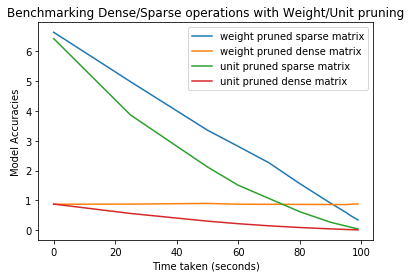

In [15]:
# we benchmark the time taken with cpu as tf is not optimised for big
# batch_size on gpu
# https://github.com/tensorflow/tensorflow/issues/12475
device = 'cpu'
pruning_types = ['weight', 'unit']

for pruning_type in pruning_types:

    for sparse in [True, False]:
        if sparse:
            sparse_prefix = 'sparse '
        else:
            sparse_prefix = 'dense '
        pruning_times = []
        print(f'\nRunning {pruning_type} pruning on {device} ' +
              f'and evaluating performance on {sparse_prefix}matrix\n')

        for percentile in PRUNE_PERCENTILES:

            test_time = prune_and_time_model(
                weights_to_prune=model.get_weights(),
                pruning_type=pruning_type,
                percentile=percentile,
                input_shape=INPUT_SHAPE,
                layer_units=LAYER_UNITS,
                sparse=sparse,
                device=device)
            print(f"Time taken for {pruning_type} pruning " +
                  f" with {percentile} weights removed is " +
                  f" {test_time:.2f} seconds")
            pruning_times.append(test_time)

        plt.plot(PRUNE_PERCENTILES, pruning_times,
                 label=pruning_type + ' pruned ' + sparse_prefix + 'matrix')

plt.xlabel('Time taken (seconds)')
plt.ylabel('Model Accuracies')
plt.legend(loc='upper right')
plt.title(f'Benchmarking Dense/Sparse operations with Weight/Unit pruning')

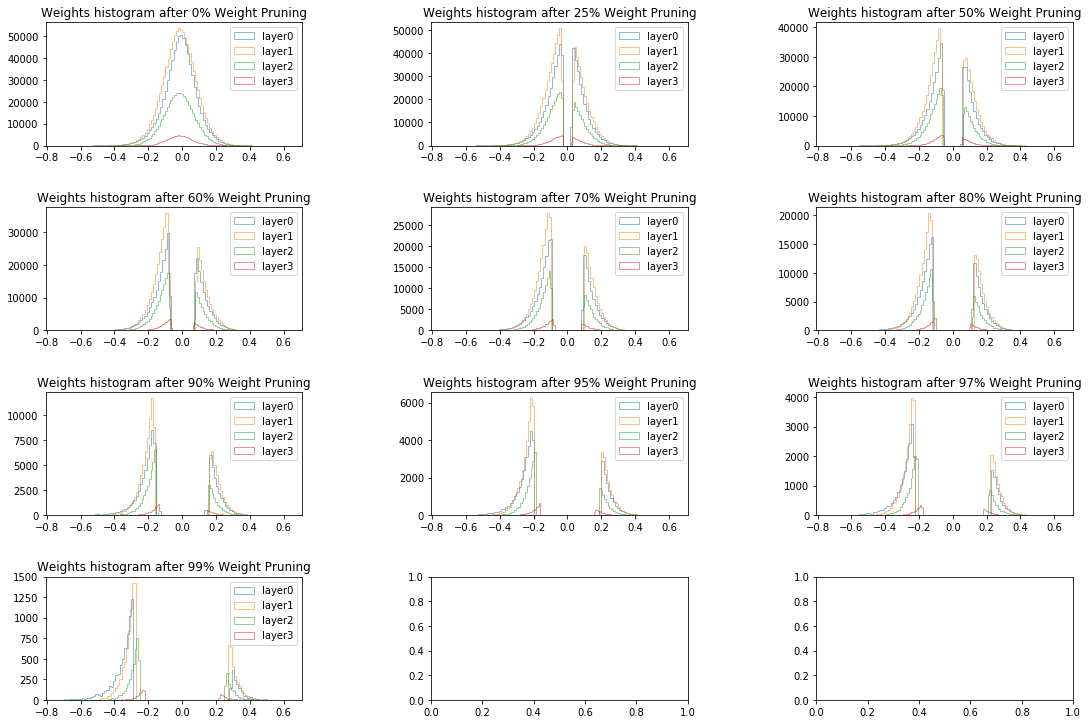

In [39]:
def plot_weight_histogram(weights, ax):
    # weights[:-1] as we dont want to analyse the 
    # last unpruned layer
    for i, weight in enumerate(weights[:-1]):
        weight = weight.reshape(-1)
        # we will only plot the non zero values
        weight = weight[weight != 0]
        ax.hist(weight, bins=100, histtype='step',
                label='layer' + str(i), alpha=0.5)
    ax.legend(loc='upper right')


def plot_column_norm_histogram(weights, ax):
    # weights[:-1] as we dont want to analyse the 
    # last unpruned layer
    for i, weight in enumerate(weights[:-1]):
        column_norms = np.linalg.norm(weight, ord=2, axis=0)
        ax.hist(column_norms, bins=100, histtype='step',
                label='layer' + str(i), alpha=0.5)
    ax.legend(loc='upper right')

    
fig, axes = plt.subplots(4, 3, figsize=(15,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.ravel()[:10]

for ax, percentile in zip(axes, PRUNE_PERCENTILES):
    pruned_weights = weight_pruning(deepcopy(model.get_weights()), percentile)
    plot_weight_histogram(pruned_weights, ax)
    ax.set_title(f'Weights histogram after {percentile}% Weight Pruning')

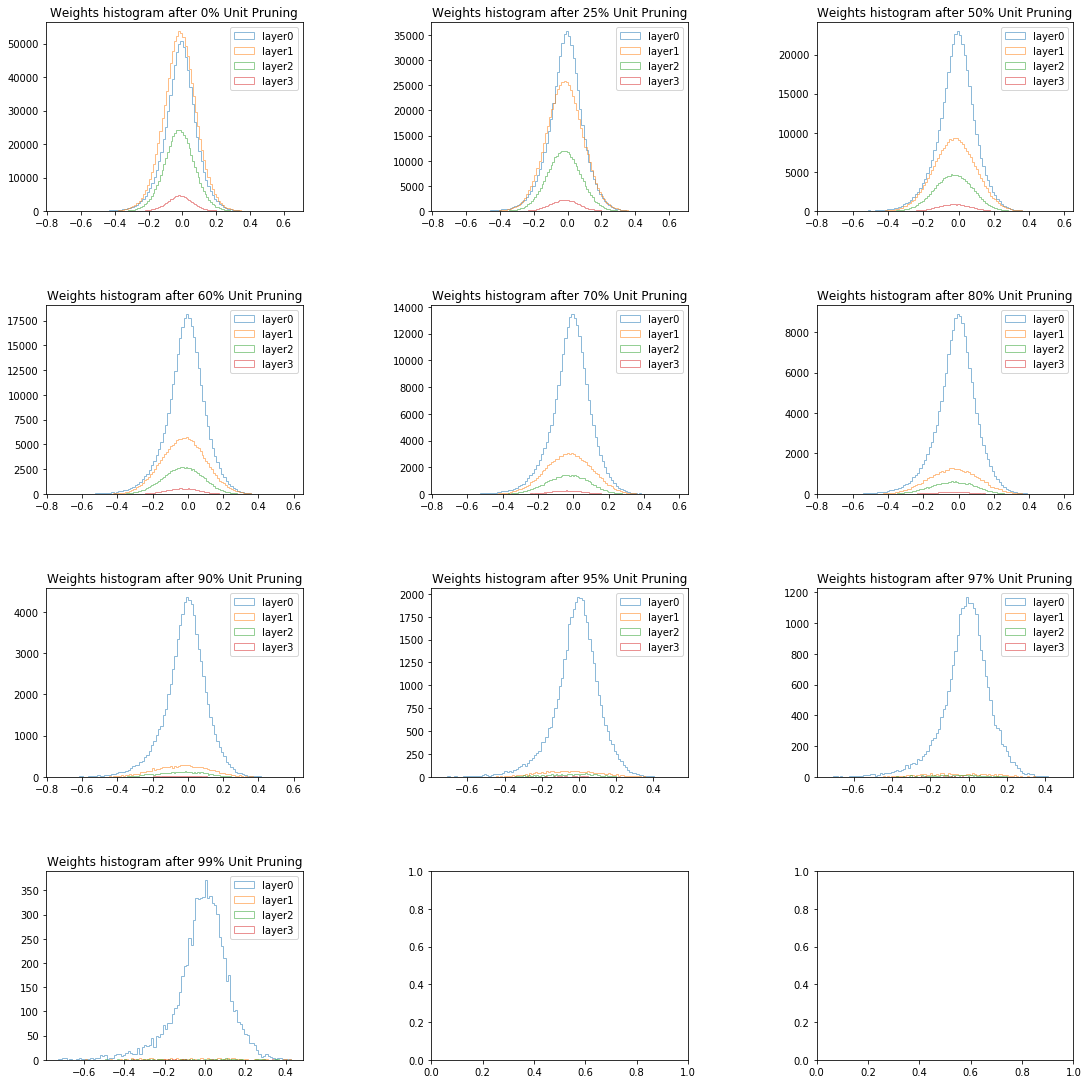

In [40]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.ravel()[:10]

for ax, percentile in zip(axes, PRUNE_PERCENTILES):
    pruned_weights, _ = unit_pruning(deepcopy(model.get_weights()), percentile)
    plot_weight_histogram(pruned_weights, ax)
    ax.set_title(f'Weights histogram after {percentile}% Unit Pruning')


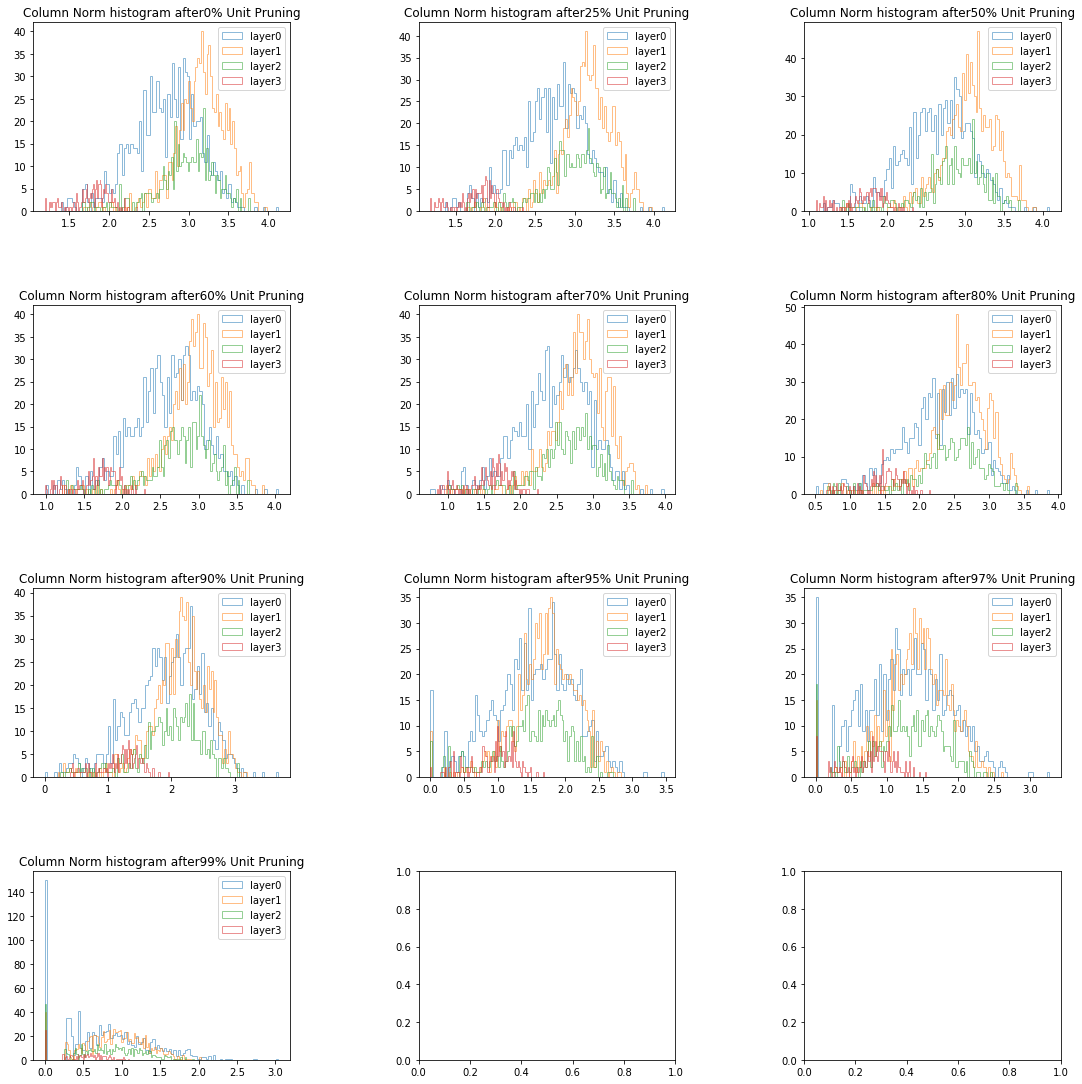

In [41]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.ravel()[:10]

for ax, percentile in zip(axes, PRUNE_PERCENTILES):
    pruned_weights = weight_pruning(deepcopy(model.get_weights()), percentile)
    plot_column_norm_histogram(pruned_weights, ax)
    ax.set_title(f'Column Norm histogram after{percentile}% Unit Pruning')

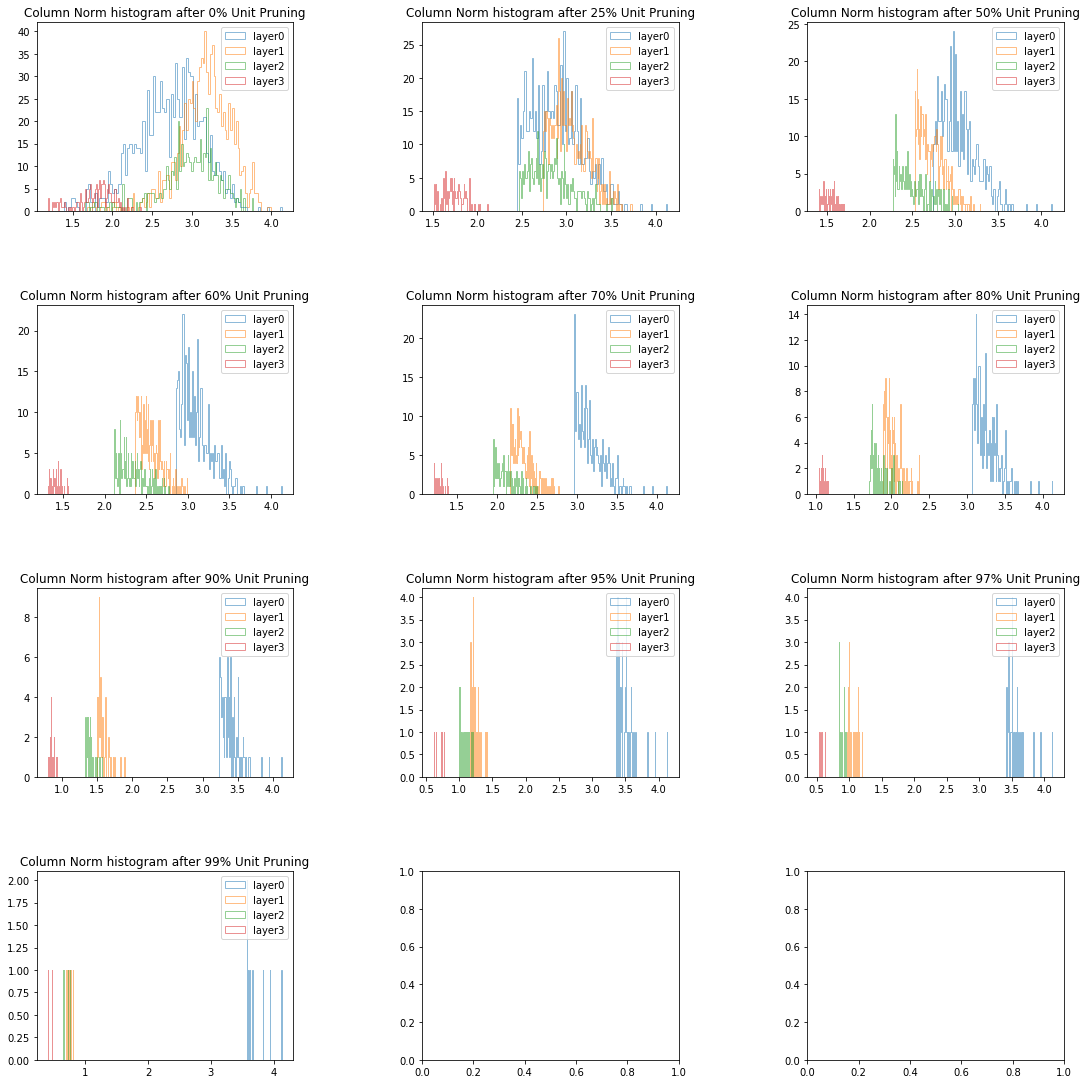

In [42]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.ravel()[:10]

for ax, percentile in zip(axes, PRUNE_PERCENTILES):
    pruned_weights, _ = unit_pruning(deepcopy(model.get_weights()), percentile)
    plot_column_norm_histogram(pruned_weights, ax)
    ax.set_title(f'Column Norm histogram after {percentile}% Unit Pruning')

**Analysis of Results**

- From the plots, we can clearly see *Weight pruning* outperforms *Unit pruning* when we are measuring model accuracy.

- In case of *Weight pruning* the performance only starts decreasing after 90% sparsity, while in the case of *Unit pruning* the decline happens much earlier starting from 70% sparsity.

- At 99% sparsity, both methods predict at random(accuracy of 10 % for classifying 10 classes)

- One of the reasons why the model's performance is not hurt even after 80% weight pruning could be that most of the values in the trained model are around 0(as seen from the plot). Perhaps we can postulate that only 10 - 15 % of the weights contribute to the task.

- The major benefit of *Unit pruning* over *Weight pruning* is the computational speed. Since we are removing neurons(whose norms are less than kth percentile) in *Unit pruning*, the model parameters reduce drastically and this enhances speed.

- Sparse linear algebra operations enhance the speed of the model in case of *Weight pruning* but only when the sparsity is significant(above 80% in this task).